# INTRODUCCIÓN

En el presente trabajo, abordamos el estudio de la Información Mutua (`IM`) entre dos series temporales correspondientes a las neuronas VD y LP bajo diferentes condiciones experimentales: estado de control, inyección de GABA y recuperación del sistema. Nuestro objetivo principal es analizar cómo los eventos de tipo `spike` y `no spike` afectan al cálculo de probabilidades y, consecuentemente, a la estimación de la IM en estas series temporales.

El análisis se realiza utilizando palabras de un solo bit hasta 8 bits, evaluando cómo varía la Información Mutua en función del tamaño de la ventana temporal seleccionada. Además, estudiamos la transferencia de entropía entre las neuronas VD y LP en ambas direcciones, incorporando la entropía normalizada para una evaluación precisa de la dinámica de transferencia de información.

Finalmente, exploramos otros métodos de representación de los eventos, como los patrones de orden y la aproximación simbólica agregada `SAX`, con el fin de comparar las distintas maneras de calcular las probabilidades y su impacto en la estimación de la IM. Estos análisis nos permitirán comprender mejor la complejidad inherente en las series temporales y cómo las distintas técnicas capturan dicha complejidad.

# DESCARGA DE LOS DATOS A EVALUAR

En caso de no poseer los datos de sobre los cuales se va a realizar la práctica siguiente, se puede ejecutar la siguiente celda que descargará automáticamente estos datos en la raiz del proyecto.

In [ ]:
"""
!pip install gdown

# Solo ejecutar esta celda si no tienes las trazas de los datos

import gdown
import zipfile
import os

file_id = '1D1gExECJbpmKupMuTisrZ3_9NMBVkD49'
output = 'datos.zip'

gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(output)
"""

# PREPARARACIÓN DEL ENTORNO DE EJECUCIÓN

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(0)

Para comodidad a la hora de tratar los datos para la creación de este notebook, se ha optado por el uso de las siguientes dos funciones `save_object` y `load_boject` para no necesitar volver a realizar calculos previamente calculados.

In [70]:
def save_object(o, name):
    with open(name,'wb') as f:
        pickle.dump(o,f)
    
def load_object(name):
    with open(name,'rb') as f:
        return pickle.load(f)

# OBSERVACIÓN DE LOS DATOS

Tras obtener los datos para la práctica, nos proponemos a leer el `TrozoG.txt`, el cual contiene a diferencia de `TrozoC.txt` y `TrozoR.txt`, 3 columnas de contenido, siendo estas LP, VD y T (siendo esta última el tiempo y duración precisa de inyección GABA al 4º spike de VD). Tras leer estos datos, mostramos los **10** primeros elementos de cada columna.

In [71]:
trozoG = pd.read_csv("Datos/TrozoG.txt", names = ["LP", "VD","T"],
                     usecols = [0, 1, 2],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoG.head(10)

,LP,VD,T
0,-0.006104,0.064697,0.120239
1,-0.004272,0.075989,0.126343
2,-0.003357,0.087280,0.125427
3,-0.005188,0.092468,0.123596
4,-0.007324,0.093384,0.118713
5,-0.010681,0.089722,0.105896
6,-0.004883,0.086975,0.127258
7,0.004272,0.092468,0.111084
8,0.002441,0.087585,0.114136
9,0.003357,0.080872,0.110779


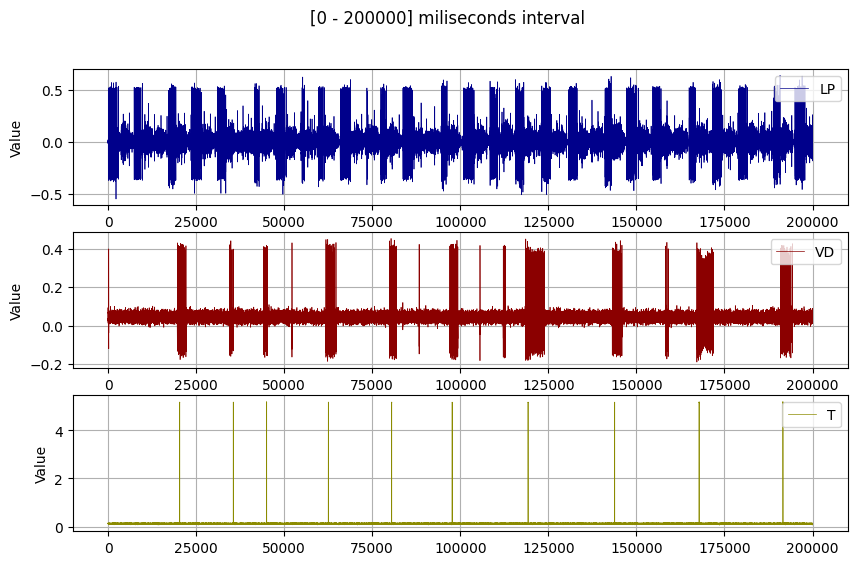

In [88]:
def plot_data_interval_lines(
            data: pd.DataFrame = None, 
            lines: list = None, 
            lines_titles: list = None, 
            x: list = [0, 10000]
    ):
    if data is None:
        raise ValueError("Data cannot be None")
    
    lines = [] if lines is None else lines
    lines_titles = [] if lines_titles is None else lines_titles

    cols = len(data.columns)
    if len(lines) > 0 and len(lines) != cols:
        raise ValueError(f"Incorrect number of lines given, sizes are {cols} and {len(lines)}")

    x_values = np.arange(x[0], x[1], 1)
    
    colors = ['#00008B', '#8B0000', '#8B8B00', '#000000']

    fig, axs = plt.subplots(cols, figsize=(10, 2 * cols))
    fig.suptitle('[{} - {}] miliseconds interval'.format(x[0], x[1]))

    if cols == 1:
        axs = [axs]

    for i in range(cols):
        axs[i].plot(x_values, data.iloc[x[0]:x[1], i], 
                    label=data.columns[i], 
                    color=colors[i], 
                    linewidth=0.5)

        if len(lines) > 0:
            y_values = [lines[i] for _ in x_values]
            axs[i].plot(x_values, y_values, 
                        color=colors[-1], 
                        label=lines_titles[i] if len(lines_titles) > i else 'Line {}'.format(i), 
                        linestyle="--", 
                        linewidth=0.5)

        axs[i].legend(loc="upper right")
        axs[i].set_ylabel('Value')
        axs[i].grid(True)

plot_data_interval_lines(trozoG, x = [0,200000])

Estos histogramas los he creado para ver más o menos las distribuciones de amplitudes de tal forma que podemos ver cuándo aumentan, es decir, que aparece el grupo de las spikes, frente al grupo del estado en reposo. Es un poco difuso las distinciones y no sé si hay alguna forma mejor de separarlas que a ojo, pero bueno. 99,7% que es lo que habían hecho Sáez y compañía me parece excesivo pero no estoy seguo. Siempre podemos preguntar al profesor o a cualquiera de estos el criterio que han seguido.

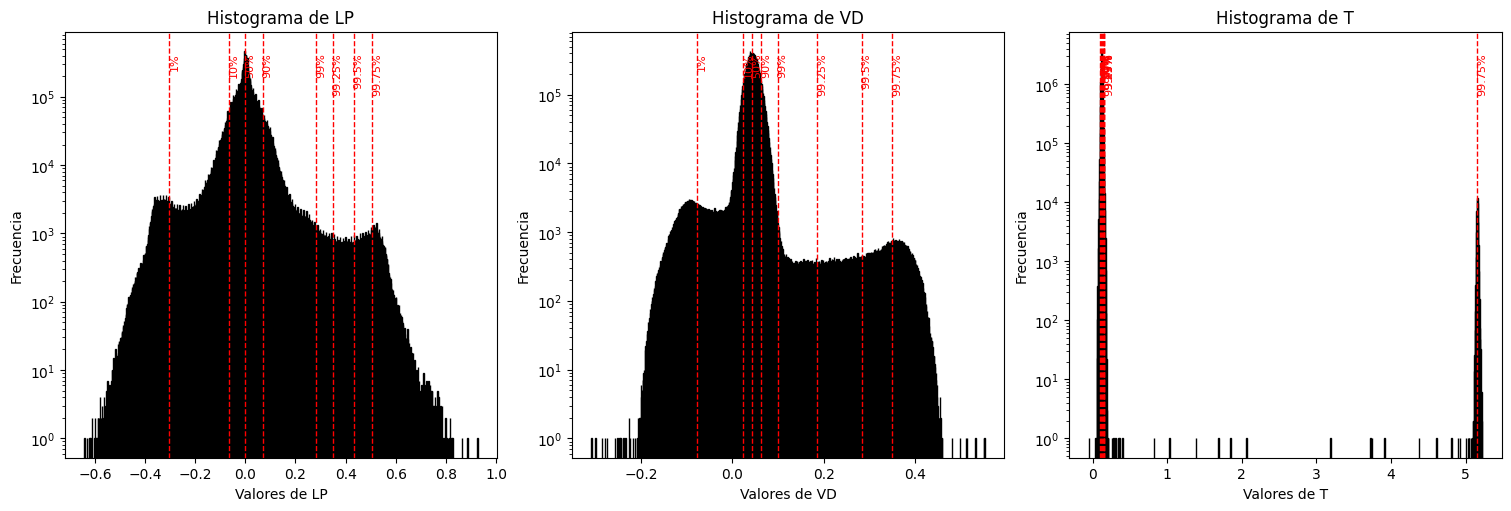

In [85]:
def plot_histograms_with_percentiles(df: pd.DataFrame, columns: list = ['LP', 'VD'], percentiles: list = [1, 10, 50, 90, 99, 99.25, 99.5, 99.75]):

    num_cols = len(columns)
    
    _, axs = plt.subplots(1, num_cols, figsize=(15, 5), constrained_layout=True)

    for i, col in enumerate(columns):
        deciles = np.percentile(df[col], percentiles)
        
        axs[i].hist(df[col], bins=1000, edgecolor='black')
        
        for decil, perc in zip(deciles, percentiles):
            axs[i].axvline(decil, color='red', linestyle='dashed', linewidth=1)
            axs[i].text(decil, axs[i].get_ylim()[1] * 0.9, f'{perc}%', 
                        rotation=90, verticalalignment='top', color='red', fontsize=8)
        
        axs[i].set_xlabel(f'Valores de {col}')
        axs[i].set_ylabel('Frecuencia')
        axs[i].set_title(f'Histograma de {col}')
        axs[i].set_yscale('log')
    
    plt.show()

columns = ['LP', 'VD', 'T']
plot_histograms_with_percentiles(trozoG, columns)

In [86]:
def get_percentiles(data: pd.DataFrame,
                    q: list = []
                    ):
    perc = data.quantile(q)
    return np.diag(perc)

Percentiles:
 [0.432129 0.282593 5.151672]


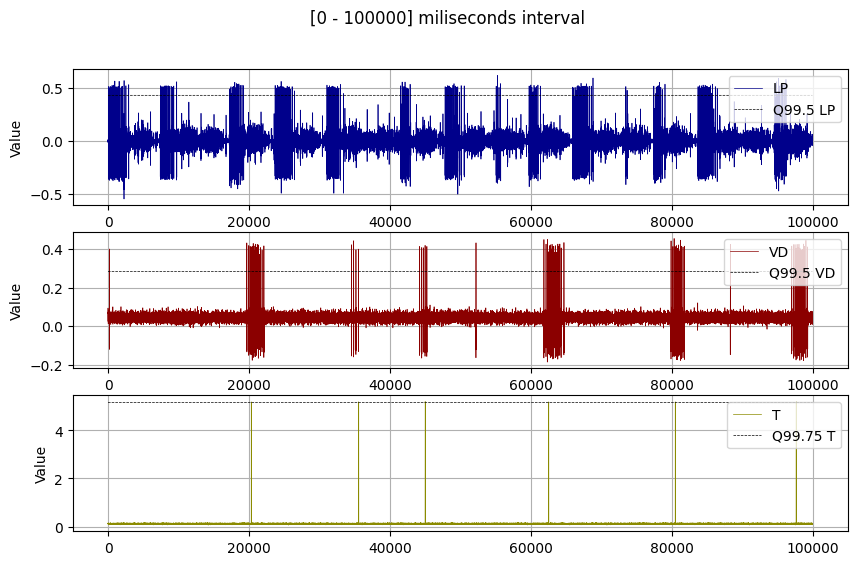

In [89]:
perc = get_percentiles(trozoG, q=[0.995, 0.995, 0.9975])
print("Percentiles:\n {}".format(perc))
plot_data_interval_lines(trozoG,
                         lines = perc,
                         lines_titles = ["Q99.5 LP", "Q99.5 VD", "Q99.75 T"],
                         x = [0,100000])

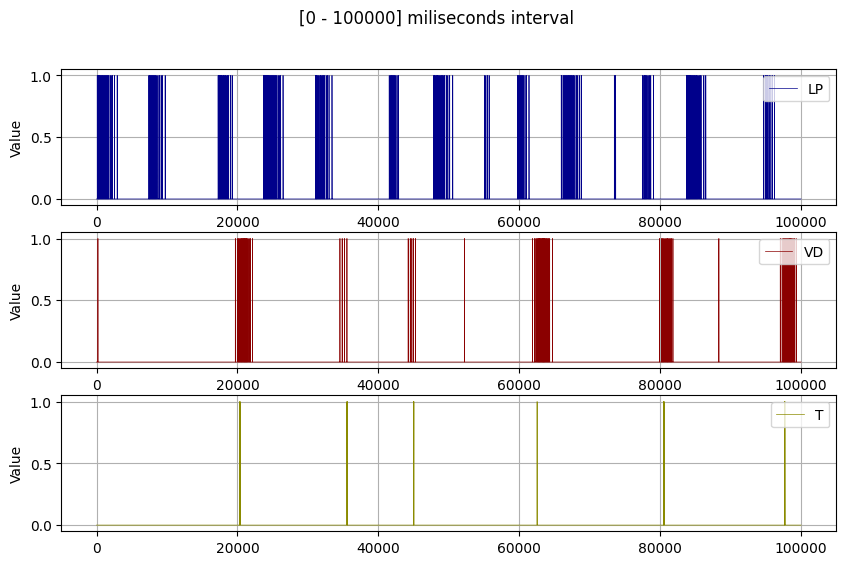

In [90]:
trozoG_umbral = (trozoG > perc).astype(int)
plot_data_interval_lines(trozoG_umbral, x =[0,100000]) 

In [91]:
trozoG_umbral.iloc[20320:20340,:]

,LP,VD,T
20320,0,0,0
20321,0,0,0
20322,0,0,0
20323,0,0,0
20324,0,0,0
20325,0,0,0
20326,0,0,0
20327,0,0,0
20328,0,1,0
20329,0,1,0


In [92]:
def _process_consecutive_ones_vector(vec, i):
    start = i
    while i < len(vec) and vec[i] == 1:
        i += 1
    end = i
    vec[start:end] = 0
    vec[start] = 1
    return i+1  # Devuelve la posicion del siguiente valor despues del 0 que sigue al spike

def minimize_ones_in_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
        Ejecución in place
    """
    for col in range(len(df.columns)):
        vec = np.array(df.iloc[:, col])
        i = 0
        while i < len(vec):
            if vec[i] == 1:
                i = _process_consecutive_ones_vector(vec, i)
            else:
                i += 1
        df.iloc[:, col] = vec
    return df

In [93]:
trozoG_minimizado = minimize_ones_in_dataframe(trozoG_umbral.copy())
trozoG_minimizado.iloc[20320:20340,:]

,LP,VD,T
20320,0,0,0
20321,0,0,0
20322,0,0,0
20323,0,0,0
20324,0,0,0
20325,0,0,0
20326,0,0,0
20327,0,0,0
20328,0,1,0
20329,0,0,0


In [94]:
import itertools

def get_zeros_between_spikes(df: pd.DataFrame) -> list[list]:
    arrays_zeros = [ [] for i in range(len(df.columns)) ]
    for idx,col in enumerate(df.columns):
        dtype = [('spike',int),('length',int)]
        vector = np.array([ (x , len(list(y)))
                    for x, y in itertools.groupby(df[col].values)],
                    dtype=dtype)
        sorted_vector = np.sort(vector,order=['spike','length'])
        arrays_zeros[idx] = np.array([v[1] for v in sorted_vector if v[0] == 0])
    return arrays_zeros

spaces_between_ones_sorted_G = get_zeros_between_spikes(trozoG_minimizado)
spaces_between_ones_sorted_G

[array([   24,    25,    44, ..., 12603, 12718, 14119]),
 array([   62,    63,    64, ..., 20802, 21351, 21408]),
 array([    1,     1,     1, ..., 44643, 72092, 76316])]

In [111]:
def plot_histograms_zoom(trace: list, yscale: str = 'log', xlims: list[int] = [750,200], xlabel: str = ""):
    import seaborn as sns

    xlims_ = sorted(xlims, reverse=True)

    trace_np = np.array(trace, dtype=np.float32)

    _ , bins = np.histogram(trace_np, bins='auto')

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(trace_np, bins=bins, ax=ax1)
    sns.histplot(trace_np, bins=bins, ax=ax2)
    sns.histplot(trace_np, bins=bins, ax=ax3)

    for ax, size in zip([ax1, ax2, ax3], [max(trace)] + xlims):
        ax.set_ylabel("")
        ax.set_xlabel(f"{xlabel} (0-{size} range)")

    ax2.set_xlim(0, xlims_[0])
    ax3.set_xlim(0, xlims_[1])

    for ax in [ax1, ax2, ax3]:
        ax.set_yscale(yscale)

    plt.tight_layout()
    plt.show()

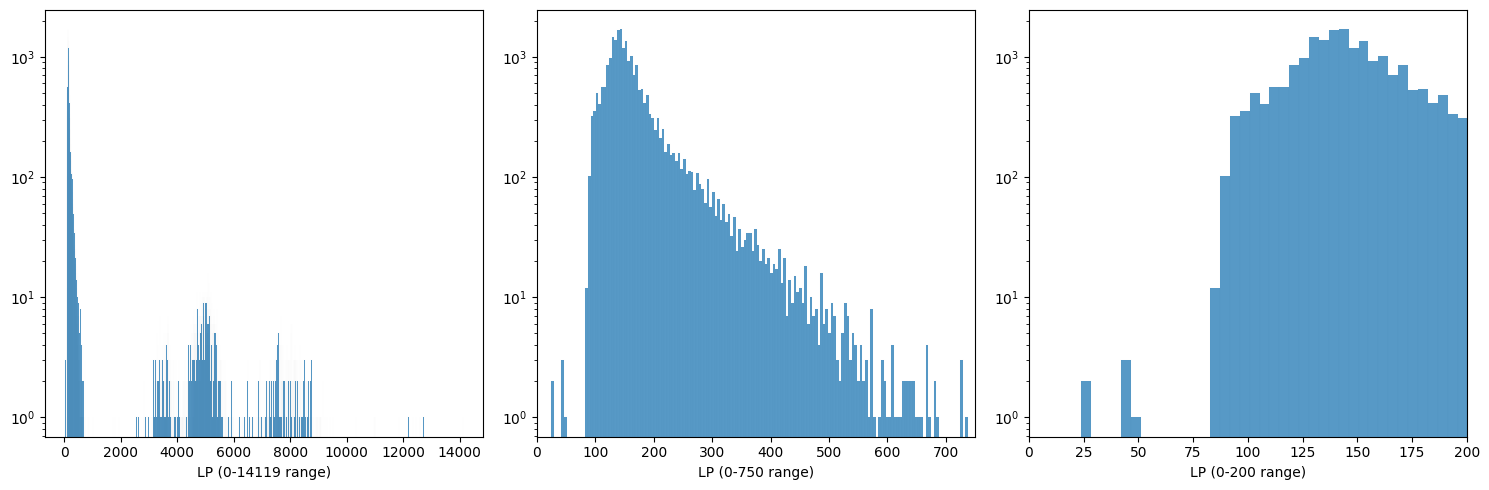

In [112]:
plot_histograms_zoom(spaces_between_ones_sorted_G[0], xlabel="LP")

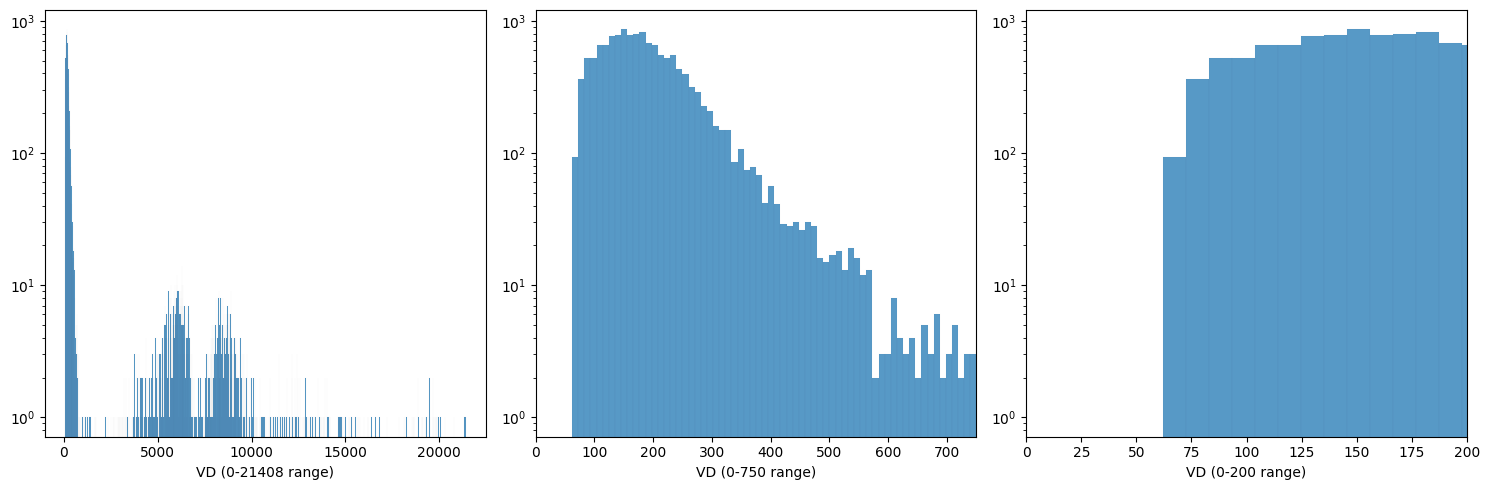

In [113]:
plot_histograms_zoom(spaces_between_ones_sorted_G[1], xlabel="VD")

In [114]:
def remove_outliers(df: pd.DataFrame, threshold_outlier: int = 55) -> pd.DataFrame:
    df_ = df.copy()
    
    for col in df_.columns:
        col_data = df_[col].values
        grouped_data = [(x, len(list(y))) for x, y in itertools.groupby(col_data)]
        
        for i, (value, length) in enumerate(grouped_data):
            if value == 0 and length < threshold_outlier:
                if i > 0:
                    grouped_data[i - 1] = (0, grouped_data[i - 1][1])
                if i < len(grouped_data) - 1:
                    grouped_data[i + 1] = (0, grouped_data[i + 1][1])
        
        df_[col] = np.concatenate([np.repeat(value, length) for value, length in grouped_data])
    
    return df_

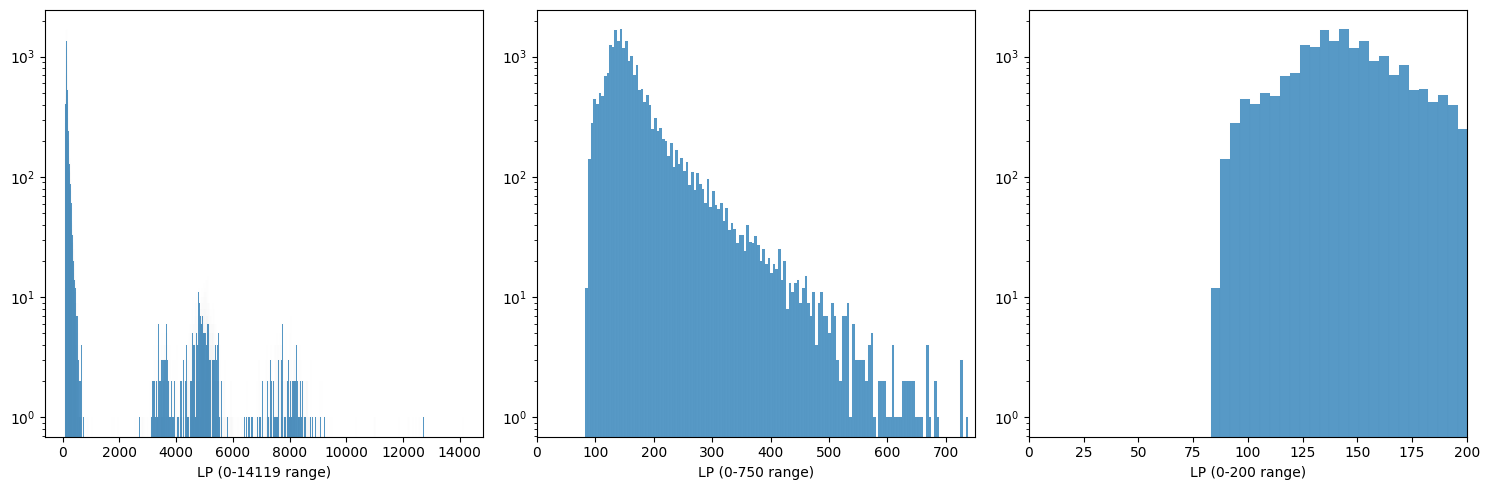

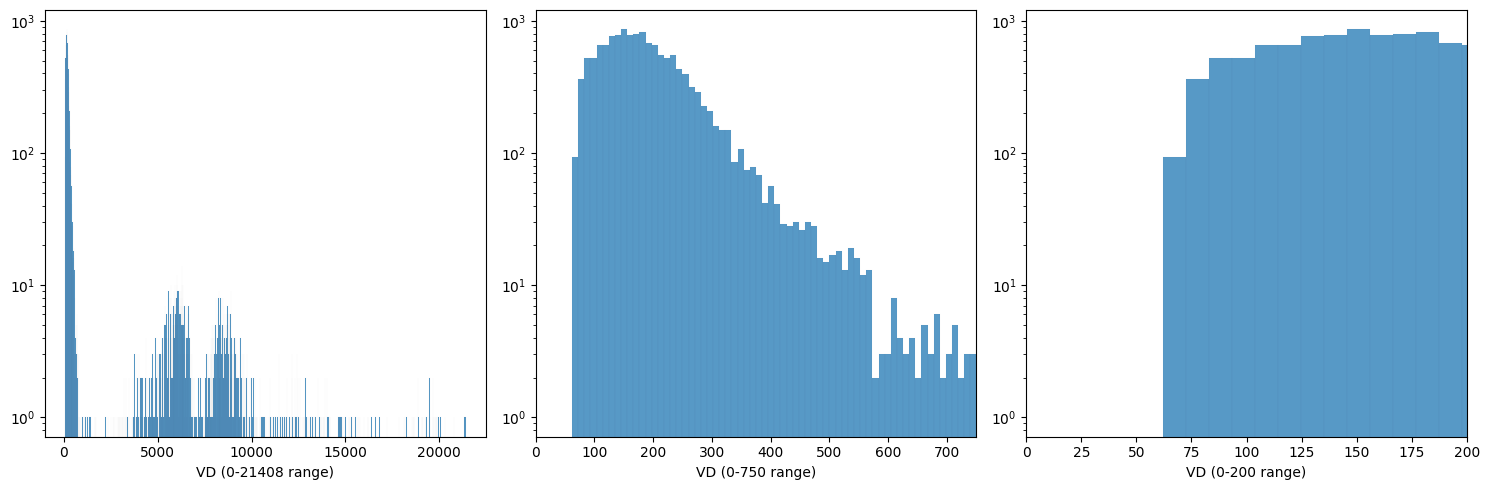

In [117]:
trozoG_no_outliers = remove_outliers(trozoG_minimizado)
spaces_no_outliers_G = get_zeros_between_spikes(trozoG_no_outliers)

for traza, typeCol in zip(spaces_no_outliers_G[:2], ["LP", "VD"]):
    plot_histograms_zoom(trace=traza, xlabel=typeCol)

In [118]:
def get_min_spaces(spaces: list[list]) -> int:

    return min(int(space_min[0]) for space_min in spaces)

windows_size_G = get_min_spaces(spaces_no_outliers_G)

In [119]:
def reduce_with_window(df, window_size):
    index = np.arange(0, len(df) + 1, window_size)
    
    result = np.zeros((len(index) - 1, df.shape[1]), dtype=int)
    
    for i, col in enumerate(df.columns):
        data = df[col].values
        for j, (i1, i2) in enumerate(zip(index[:-1], index[1:])):
            if np.any(data[i1:i2] == 1):
                result[j, i] = 1
    
    return pd.DataFrame(result, columns=df.columns)

In [120]:
def _create_discretization(trace: pd.DataFrame, q: list[int]) -> pd.DataFrame:
    perc = get_percentiles(trace, q=q)
    trace_threshold = (trace > perc).astype(int)
    trace_minimized = minimize_ones_in_dataframe(trace_threshold.copy())
    return remove_outliers(trace_minimized)

def _create_reduction(trace_no_outliners: pd.DataFrame, windows_size: int = None) -> pd.DataFrame:
    if not windows_size:
        spaces = get_zeros_between_spikes(trace_no_outliners)

        windows_size = get_min_spaces(spaces)

        print(f"Tamaño de ventana {windows_size}")
    return reduce_with_window(trace_no_outliners, windows_size)

def compute_trace(trace: pd.DataFrame, q: list[int], windows_size: int = None) -> pd.DataFrame:
    discretized_trace = _create_discretization(trace, q)
    return _create_reduction(discretized_trace, windows_size)

trozoG_reducido = compute_trace(trozoG, [0.995, 0.995, 0.9975])

Tamaño de ventana 62


In [130]:
def get_reduced_percentage(trace_reduced: pd.DataFrame, trace: pd.DataFrame) -> float:
    return len(trace_reduced.iloc[:,0])/len(trace.iloc[:,0])*100

get_reduced_percentage(trozoG_reducido, trozoG)

1.61290283203125

## TROZO C

In [122]:
trozoC = pd.read_csv("Datos/TrozoC.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoC.head(10)

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471
5,-0.034180,0.047913
6,-0.045166,0.058899
7,-0.048523,0.057068
8,-0.049438,0.062256
9,-0.048828,0.064697


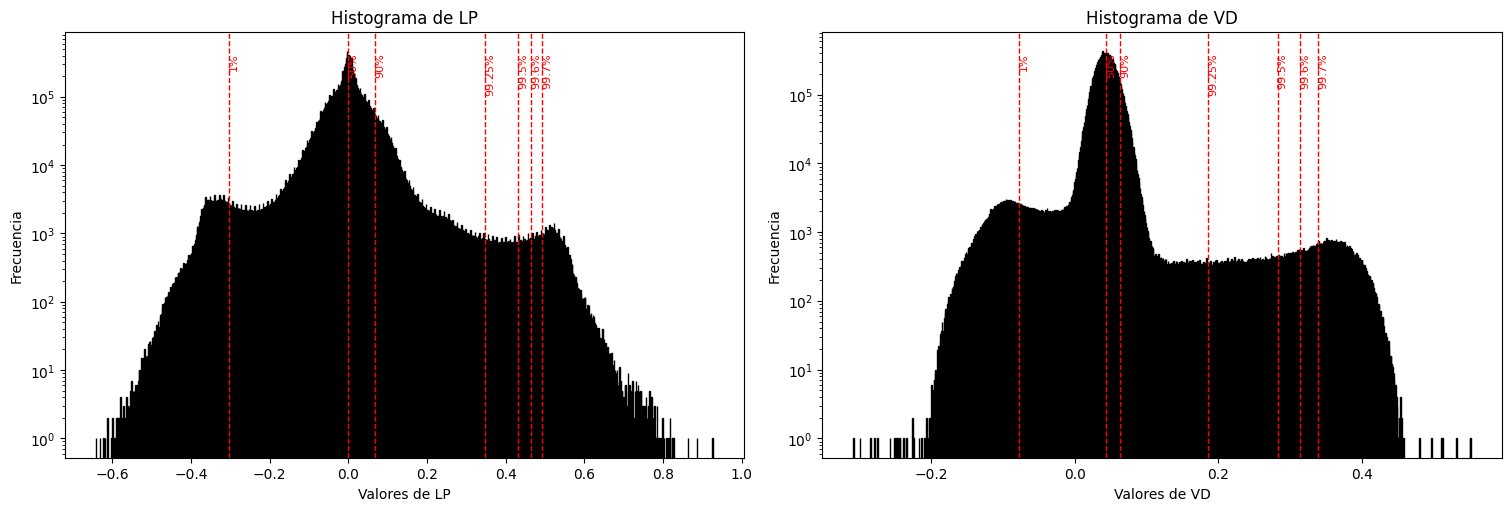

In [123]:
percentiles = [1, 50, 90, 99.25, 99.5, 99.6, 99.7]
plot_histograms_with_percentiles(trozoG, percentiles=percentiles)

In [124]:
trozoC_reducido = compute_trace(trozoC, [0.996, 0.995])

Tamaño de ventana 60


In [125]:
get_reduced_percentage(trozoC_reducido, trozoC)

1.6666666666666667

## TROZO R

In [126]:
trozoR = pd.read_csv("Datos/TrozoR.txt", names = ["LP", "VD"],
                     usecols = [0, 1],
                     delimiter = "\t", skiprows = range(3), 
                     index_col = False, decimal = ",")

trozoR.head(10)

,LP,VD
0,-0.008240,0.084534
1,-0.009460,0.070190
2,-0.014038,0.049133
3,-0.021973,0.035400
4,-0.035095,0.022888
5,-0.042114,0.008850
6,-0.047607,0.009460
7,-0.057678,0.012207
8,-0.061646,0.018311
9,-0.086060,0.021973


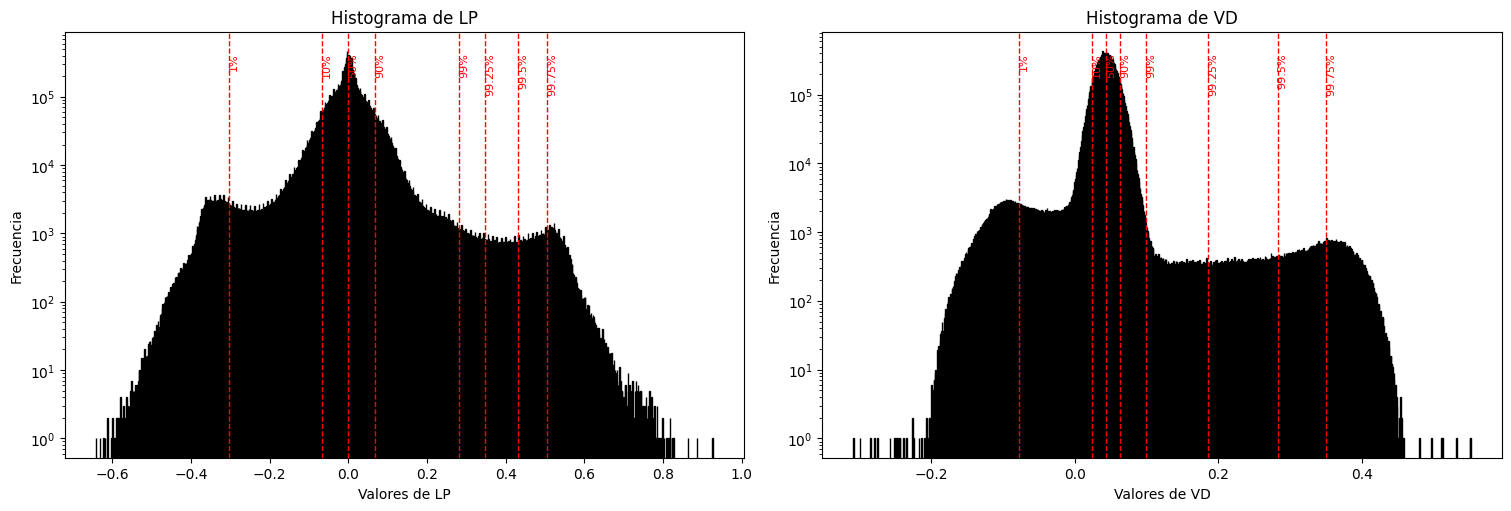

In [132]:

plot_histograms_with_percentiles(trozoG)

In [128]:
trozoR_reducido = compute_trace(trozoR, [0.995, 0.995])

Tamaño de ventana 60


In [131]:
get_reduced_percentage(trozoR_reducido, trozoR)

1.66666259765625